# AI in Biomedicine and Healthcare [BM5020]
# Project : Vessel and tissue recognition during third-space Endoscopy using a deep learning algorithm
## Team Members
- **Pradeep Mundlik, ai21btech11022@iith.ac.in**
- **Naman Chhibbar, ma21btech11011@iith.ac.in**

#### Link to Github Repository: [Github](https://github.com/NamanChhibbar/BM5020-Project)
#### Link to Paper PPT: [Slides](https://docs.google.com/presentation/d/1uuP4rpO48ZUkxz7x2UBRvn2n522-tvPUc-YlY8JwQa8/edit?usp=sharing)


***This notebook contains the main code for the project. It includes the implementation of various algorithms and functions related to the project along with output to help with our analysis.***

In [1]:
# importing resnest model from timm library
import numpy as np, matplotlib.pyplot as plt, timm, torch, torch.nn.functional as F, torchvision.transforms as T, cv2
from PIL import Image
from torch import nn
from torchvision import models
from torchsummary import summary
from torchviz import make_dot
from matplotlib import cm

In [2]:
# defining the model
class Resnest(nn.Module):
    def __init__(self, model_name='resnest101e', pretrained=True):
        super(Resnest, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        # self.model.fc = nn.Linear(n_features, 10)
        self.model.fc = nn.Identity(n_features)

    def forward(self, x):
        x = self.model(x)
        print(x.shape)
        x = x.unsqueeze(2)
        x = x.unsqueeze(2)
        print(x.shape)
        return {"out": x}
    
# define the preprocessing function
def preprocess(image):
    image = image.convert('RGB')
    image = np.array(image)
    image = np.transpose(image, (2, 0, 1))
    image = torch.tensor(image, dtype=torch.float32)
    image /= 255
    normalise = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = normalise(image)
    return image

In [3]:
# load model
# model = Resnest()
# # print(model)
# model.eval()

# # load image
# image = Image.open('dog.jpg')
# image = preprocess(image)

# # predict
# with torch.no_grad():
#     features = model(image.unsqueeze(0))
#     # pred = torch.sigmoid(pred)
#     pred = features.numpy()

# pred = np.squeeze(pred)
# print(pred.shape)

# print(summary(model, input_size=(3, 244, 244)))
x  = torch.ones((1,2048))
x = x.unsqueeze(2)
x = x.unsqueeze(2)
print(x.shape)

torch.Size([1, 2048, 1, 1])


In [4]:
# define the model
clf = models.segmentation.deeplabv3.DeepLabHead(2048, 3)
model = models.segmentation.DeepLabV3(backbone=Resnest(), classifier=clf)
print(model)

DeepLabV3(
  (backbone): Resnest(
    (model): ResNet(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): ResNestBottleneck(
          (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm

In [5]:
# try to visualize the model
image = Image.open('dog.jpg')
image = preprocess(image)
model.eval()

# predict
with torch.no_grad():
    output = model(image.unsqueeze(0))
print(output)

torch.Size([1, 2048])
torch.Size([1, 2048, 1, 1])
OrderedDict({'out': tensor([[[[-0.0514, -0.0514, -0.0514,  ..., -0.0514, -0.0514, -0.0514],
          [-0.0514, -0.0514, -0.0514,  ..., -0.0514, -0.0514, -0.0514],
          [-0.0514, -0.0514, -0.0514,  ..., -0.0514, -0.0514, -0.0514],
          ...,
          [-0.0514, -0.0514, -0.0514,  ..., -0.0514, -0.0514, -0.0514],
          [-0.0514, -0.0514, -0.0514,  ..., -0.0514, -0.0514, -0.0514],
          [-0.0514, -0.0514, -0.0514,  ..., -0.0514, -0.0514, -0.0514]],

         [[ 0.0301,  0.0301,  0.0301,  ...,  0.0301,  0.0301,  0.0301],
          [ 0.0301,  0.0301,  0.0301,  ...,  0.0301,  0.0301,  0.0301],
          [ 0.0301,  0.0301,  0.0301,  ...,  0.0301,  0.0301,  0.0301],
          ...,
          [ 0.0301,  0.0301,  0.0301,  ...,  0.0301,  0.0301,  0.0301],
          [ 0.0301,  0.0301,  0.0301,  ...,  0.0301,  0.0301,  0.0301],
          [ 0.0301,  0.0301,  0.0301,  ...,  0.0301,  0.0301,  0.0301]],

         [[-0.0445, -0.0445, -0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1213, 1546])
torch.Size([3, 1213, 1546])
torch.Size([1213, 1546, 3])


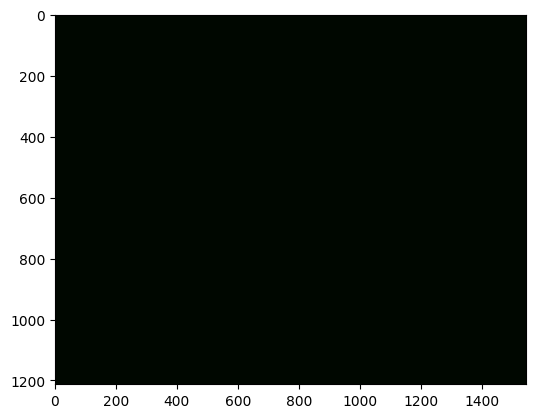

In [6]:
print(output['out'].shape)
print(image.shape)

out_image = output['out'][0]
out_image = np.transpose(out_image, (1, 2, 0))
print(out_image.shape)

plt.imshow(out_image)

In [7]:
# import deeplatv3+ model from torchvision
model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT)

# try to visualize the model
image = Image.open('dog.jpg')
image = preprocess(image)
model.eval()

# predict
with torch.no_grad():
    output = model(image.unsqueeze(0))
    print(output)
    
print(output['out'].shape)

out_image = output['out']
print(out_image.shape)

OrderedDict({'out': tensor([[[[ 6.5472e+00,  6.5472e+00,  6.5472e+00,  ...,  7.8123e+00,
            7.8123e+00,  7.8123e+00],
          [ 6.5472e+00,  6.5472e+00,  6.5472e+00,  ...,  7.8123e+00,
            7.8123e+00,  7.8123e+00],
          [ 6.5472e+00,  6.5472e+00,  6.5472e+00,  ...,  7.8123e+00,
            7.8123e+00,  7.8123e+00],
          ...,
          [ 7.6681e+00,  7.6681e+00,  7.6681e+00,  ...,  8.3408e+00,
            8.3408e+00,  8.3408e+00],
          [ 7.6681e+00,  7.6681e+00,  7.6681e+00,  ...,  8.3408e+00,
            8.3408e+00,  8.3408e+00],
          [ 7.6681e+00,  7.6681e+00,  7.6681e+00,  ...,  8.3408e+00,
            8.3408e+00,  8.3408e+00]],

         [[-2.1309e+00, -2.1309e+00, -2.1309e+00,  ..., -2.0512e+00,
           -2.0512e+00, -2.0512e+00],
          [-2.1309e+00, -2.1309e+00, -2.1309e+00,  ..., -2.0512e+00,
           -2.0512e+00, -2.0512e+00],
          [-2.1309e+00, -2.1309e+00, -2.1309e+00,  ..., -2.0512e+00,
           -2.0512e+00, -2.0512e+00],


In [8]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [9]:
def postprocess_output(output, num_classes):
    output_np = output.cpu().numpy().squeeze()
    segmentation_map = np.argmax(output_np, axis=0)
    segmentation_map = cm.tab20(segmentation_map.astype(float) / num_classes)
    return segmentation_map

def overlay_segmentation_mask(image, segmentation_map):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.addWeighted(image, 0.5, segmentation_map, 0.5, 0)
    return image

def visualize_results(image, segmentation_map):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Input Image')
    axs[1].imshow(segmentation_map)
    axs[1].set_title('Segmentation Mask')
    axs[2].imshow(overlay_segmentation_mask(image, segmentation_map))
    axs[2].set_title('Overlay')
    plt.show()

In [10]:
out_image = postprocess_output(out_image, 21)
print(out_image.shape)

(1213, 1546, 4)
